## Загрузка данных

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import random
import seaborn as sns
import torch
import torch.nn as nn

from math import ceil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler



from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import  mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn


import skorch
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch import NeuralNetRegressor

import random

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/6_class.csv', index_col='Unnamed: 0')

## Предобработка и анализ данных

In [3]:
df

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,8829,537493.000000,1423.0000,-10.73,5,White
238,9235,404940.000000,1112.0000,-11.23,5,White


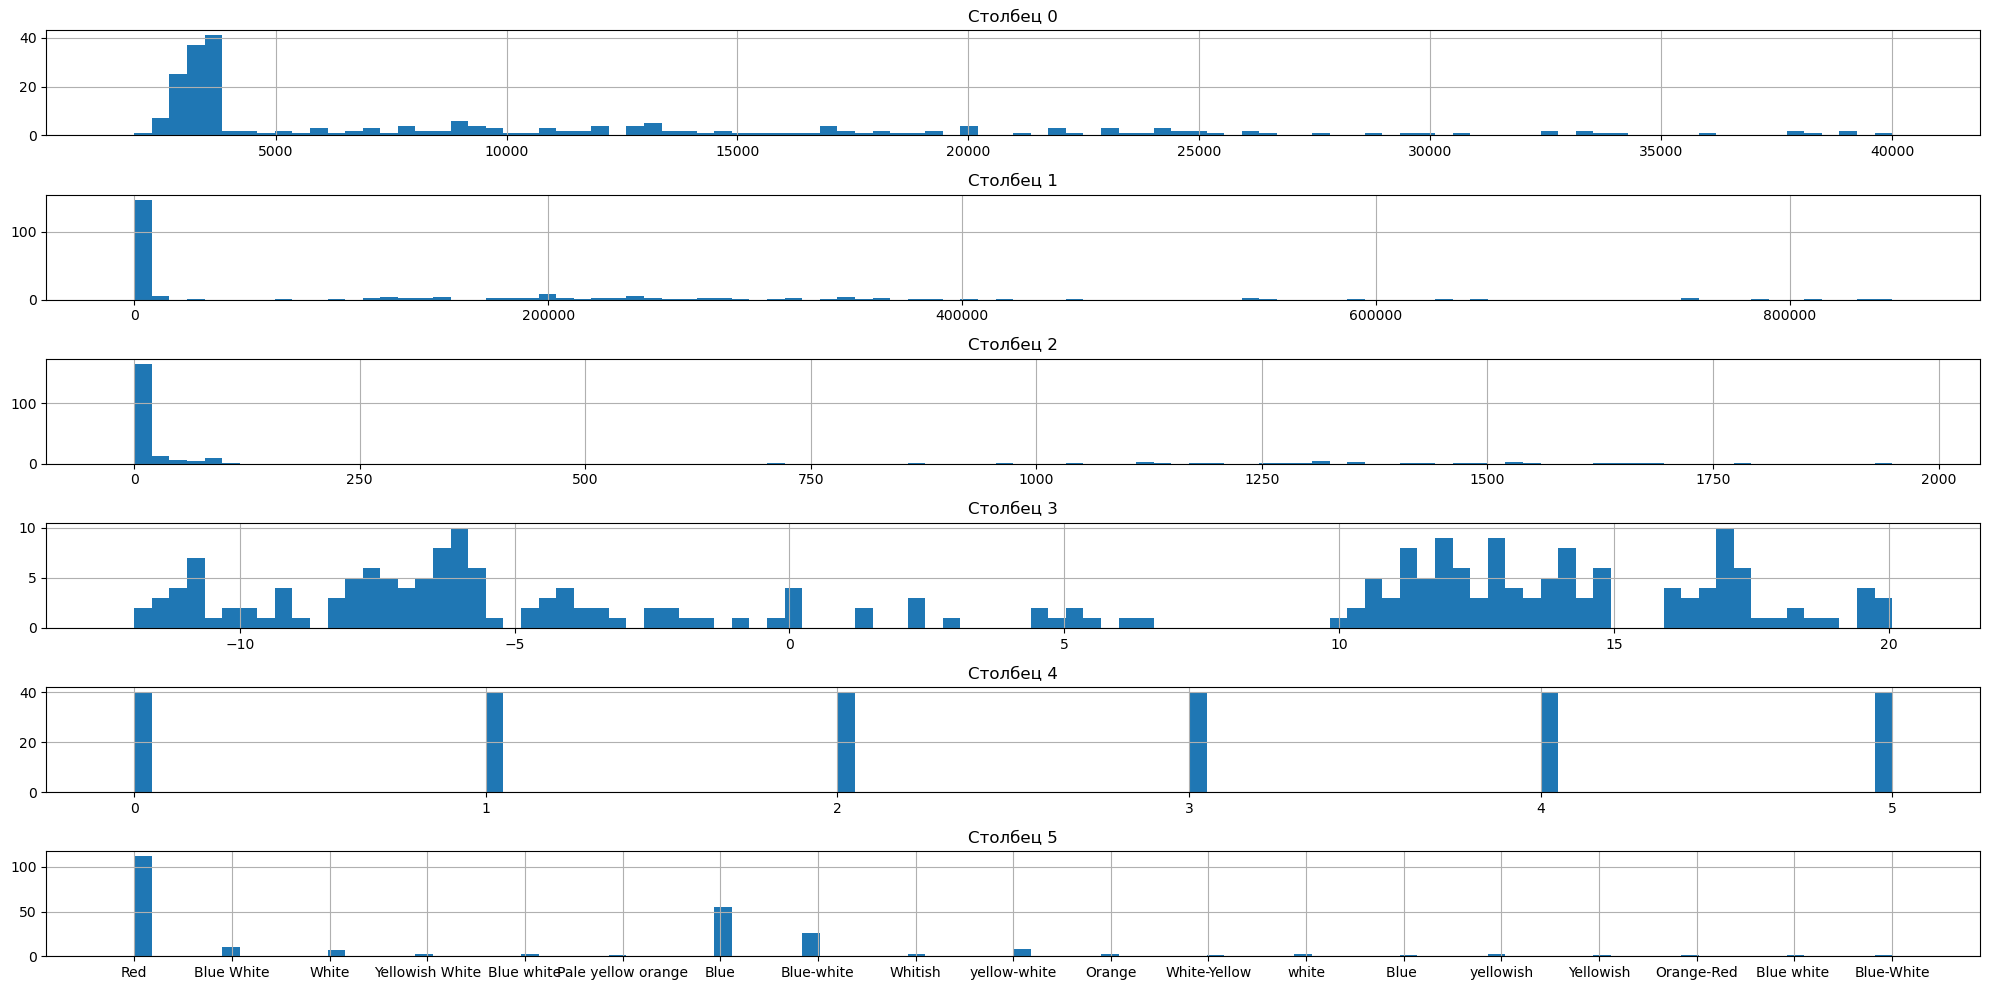

In [4]:
num_columns = df.shape[1]
num_rows = 6
num_cols = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    if i < num_columns:
        df.iloc[:, i].hist(bins=100, ax=ax)
        ax.set_title(f'Столбец {i}')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
df['Star color'] = OrdinalEncoder().fit_transform(df[['Star color']])

In [6]:
y = df["Temperature (K)"]
X = df.drop("Temperature (K)", axis=1)

In [7]:
scaler = StandardScaler()
columns_X = X.columns
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=columns_X)

del scaler
del columns_X

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [9]:
X_train_tensor = torch.FloatTensor(X_train.values) 
X_test_tensor = torch.FloatTensor(X_test.values)
y_train_tensor = torch.FloatTensor(y_train.values)
y_test_tensor = torch.FloatTensor(y_test.values)

## Построение базовой нейронной сети

In [10]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [11]:
num_epochs = 500
learning_rate = 0.07

In [12]:
def init_weights(layer):
    
    if type(layer) == nn.Linear: 
        nn.init.normal_(layer.weight, mean= 0.0, std=1.14)
        nn.init.normal_(layer.bias, mean=-0.5, std=1.0) 

In [13]:
results_loss_1 = [] 
results_time_1 = [] 
results_loss_2 = [] 

n_in_neurons = X_train_tensor.shape[1]
n_hidden_neurons_1 = 10
n_hidden_neurons_2 = 10
n_out_neurons = 1 

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ELU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ELU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons),
    nn.ReLU()
)

net.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss = nn.MSELoss()

In [16]:
for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()
    preds = net.forward(X_train_tensor).flatten()
     
    loss_value = loss(preds, y_train_tensor)
    loss_value.backward()
    optimizer.step()

    with torch.no_grad():   
            net.eval()
            test_preds = net.forward(X_test_tensor).flatten()
            loss_value_test = loss(test_preds, y_test_tensor) 
            print('epoch {}, RMSE train {:.4f}, RMSE test {:.4f}'.format(epoch, torch.Tensor.sqrt_(loss_value),\
                                                                            torch.Tensor.sqrt_(loss_value_test)))                
            
            results_loss_1.append(loss_value.tolist())
            results_time_1.append(epoch)
            results_loss_2.append(loss_value_test.tolist())
                
       
print('')
print('Лучшее значение RMSE train: ', min(results_loss_1))
print('Лучшее значение RMSE test: ', min(results_loss_2))

epoch 0, RMSE train 4168.9912, RMSE test 4552.1733
epoch 1, RMSE train 4167.6982, RMSE test 4551.0132
epoch 2, RMSE train 4166.4146, RMSE test 4549.9209
epoch 3, RMSE train 4165.1143, RMSE test 4549.9023
epoch 4, RMSE train 4163.7656, RMSE test 4551.0889
epoch 5, RMSE train 4162.3545, RMSE test 4552.0898
epoch 6, RMSE train 4160.8896, RMSE test 4552.3218
epoch 7, RMSE train 4159.3784, RMSE test 4552.0835
epoch 8, RMSE train 4157.8267, RMSE test 4552.1899
epoch 9, RMSE train 4156.2241, RMSE test 4552.6133
epoch 10, RMSE train 4154.5679, RMSE test 4552.7881
epoch 11, RMSE train 4152.8784, RMSE test 4552.9424
epoch 12, RMSE train 4151.1499, RMSE test 4553.1357
epoch 13, RMSE train 4149.3867, RMSE test 4552.9146
epoch 14, RMSE train 4147.6040, RMSE test 4552.7969
epoch 15, RMSE train 4145.8037, RMSE test 4552.7500
epoch 16, RMSE train 4143.9648, RMSE test 4552.8682
epoch 17, RMSE train 4142.0928, RMSE test 4553.0942
epoch 18, RMSE train 4140.2173, RMSE test 4553.6890
epoch 19, RMSE train 4

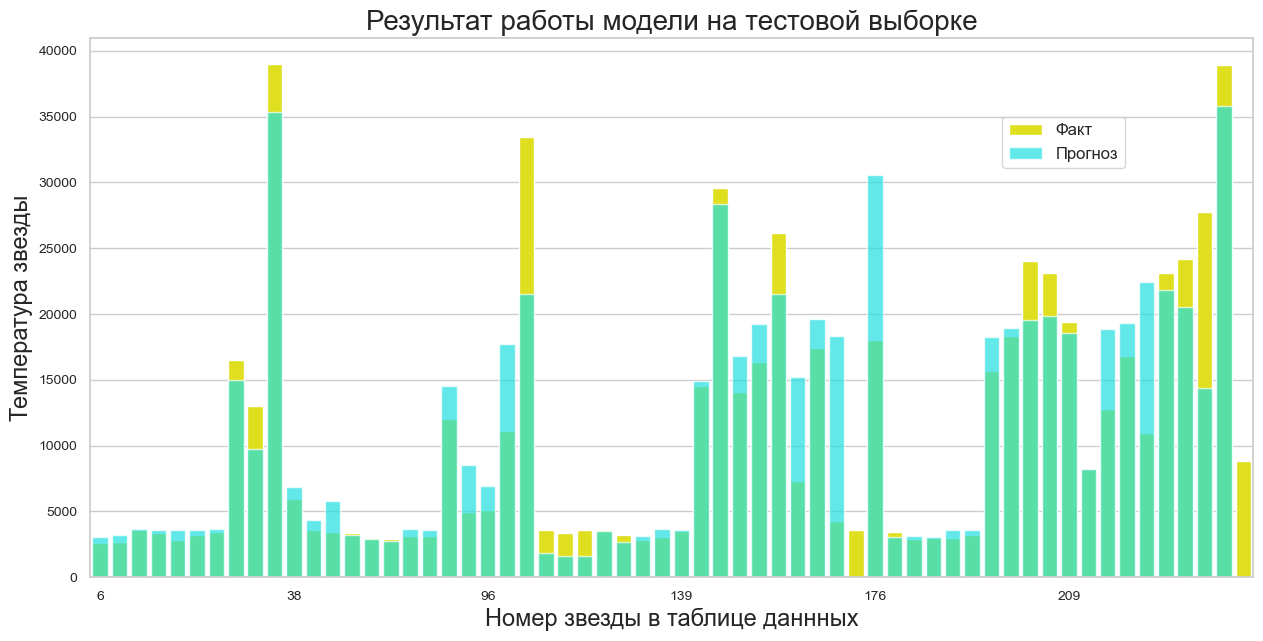

In [17]:
x = pd.concat([y_test.reset_index(), pd.Series(test_preds.flatten().detach().numpy())], axis=1)

sns.set(style="whitegrid")
fig_1=plt.figure(1, figsize=(15, 7))


sns.barplot(data=x, x='index', y='Temperature (K)', color ='yellow', alpha = 1, label='Факт')
sns.barplot(data=x, x='index', y=0, color ='cyan', alpha = 0.7, label='Прогноз')

plt.xticks(ticks=np.arange(0, len(x), 10), fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(0.897,0.87), prop={'size':12})
plt.xlabel('Номер звезды в таблице даннных', fontsize=17)
plt.ylabel('Температура звезды', fontsize=17)
plt.title('Результат работы модели на тестовой выборке', fontsize=20)
plt.draw()

## Улучшение нейронной сети

In [18]:

X_train_n, X_valid_n, y_train_n, y_valid_n = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

print(X_train_n.shape, y_train_n.shape, X_valid_n.shape, y_valid_n.shape)
X_train_n_tensor = torch.FloatTensor(X_train_n.values) 
X_valid_n_tensor = torch.FloatTensor(X_valid_n.values)
y_train_n_tensor = torch.FloatTensor(y_train_n.values)
y_valid_n_tensor = torch.FloatTensor(y_valid_n.values)

(135, 5) (135,) (45, 5) (45,)


In [24]:
batch_size = [8, 16, 24, 32]

def init_weights_n(layer):
    
    if type(layer) == nn.Linear: 
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu') 
        nn.init.normal_(layer.bias, mean=-0.5, std=1.0) 
        
results_loss_3 = []
results_time_3 = []
results_size_3 = []

n_in_neurons = X_train_n_tensor.shape[1]
n_hidden_neurons_1 = 4
n_hidden_neurons_2 = 3
n_out_neurons = 1 

net_2 = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ELU(),
    nn.BatchNorm1d(n_hidden_neurons_1),    
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ELU(),
    nn.BatchNorm1d(n_hidden_neurons_2),    
    nn.Linear(n_hidden_neurons_2, n_out_neurons),
    nn.ReLU()
)    

In [27]:
for size in batch_size:
        
        net_2.apply(init_weights_n)
        optimizer = torch.optim.Adam(net_2.parameters(), lr=learning_rate)
        loss = nn.MSELoss()
        num_batches = ceil(len(X_train_n)/size)
                
        for epoch in range(num_epochs):
            order = np.random.permutation(len(X_train_n)) 
            for batch_idx in range(num_batches):
        
                start_index = batch_idx * size 
                net_2.train()
                optimizer.zero_grad()
        
                batch_indexes = order[start_index:start_index+size] 
                X_batch = X_train_n_tensor[batch_indexes]
                y_batch = y_train_n_tensor[batch_indexes]
        
                preds = net_2.forward(X_batch).flatten()
          
                loss_value = loss(preds, y_batch)
                loss_value.backward()
                optimizer.step()
                
            with torch.no_grad():
            
                net_2.eval()
                test_preds = net_2.forward(X_valid_n_tensor).flatten()
                loss_value_valid = loss(test_preds, y_valid_n_tensor)
                print('size {}, epoch {}, RMSE train {:.4f}, RMSE valid {:.4f}'.format(size, epoch, \
                                                    torch.Tensor.sqrt_(loss_value), torch.Tensor.sqrt_(loss_value_valid)))  
                results_loss_3.append(loss_value_valid.tolist())
                results_time_3.append(epoch)
                results_size_3.append(size)

index = results_loss_3.index(min(results_loss_3))
print('')
print('Лучшее значение RMSE valid: size {}, epoch {}, RMSE {:.4f}'.format(results_size_3[index], \
                                                                              results_time_3[index], min(results_loss_3))) 

size 8, epoch 0, RMSE train 13789.3174, RMSE valid 14018.3281
size 8, epoch 1, RMSE train 13634.2324, RMSE valid 13272.0850
size 8, epoch 2, RMSE train 7223.7725, RMSE valid 12584.8467
size 8, epoch 3, RMSE train 11179.3955, RMSE valid 11903.8486
size 8, epoch 4, RMSE train 17228.1523, RMSE valid 11457.8486
size 8, epoch 5, RMSE train 8448.7383, RMSE valid 10806.8281
size 8, epoch 6, RMSE train 4642.0605, RMSE valid 10258.7715
size 8, epoch 7, RMSE train 3831.1338, RMSE valid 9423.3926
size 8, epoch 8, RMSE train 7186.1460, RMSE valid 9049.4297
size 8, epoch 9, RMSE train 3906.9209, RMSE valid 9130.3691
size 8, epoch 10, RMSE train 5580.8794, RMSE valid 8453.2285
size 8, epoch 11, RMSE train 12931.8350, RMSE valid 8283.6484
size 8, epoch 12, RMSE train 4965.8145, RMSE valid 8090.8584
size 8, epoch 13, RMSE train 8822.8467, RMSE valid 7998.6045
size 8, epoch 14, RMSE train 2824.8171, RMSE valid 7462.0415
size 8, epoch 15, RMSE train 4669.3130, RMSE valid 7834.2603
size 8, epoch 16, RMSE

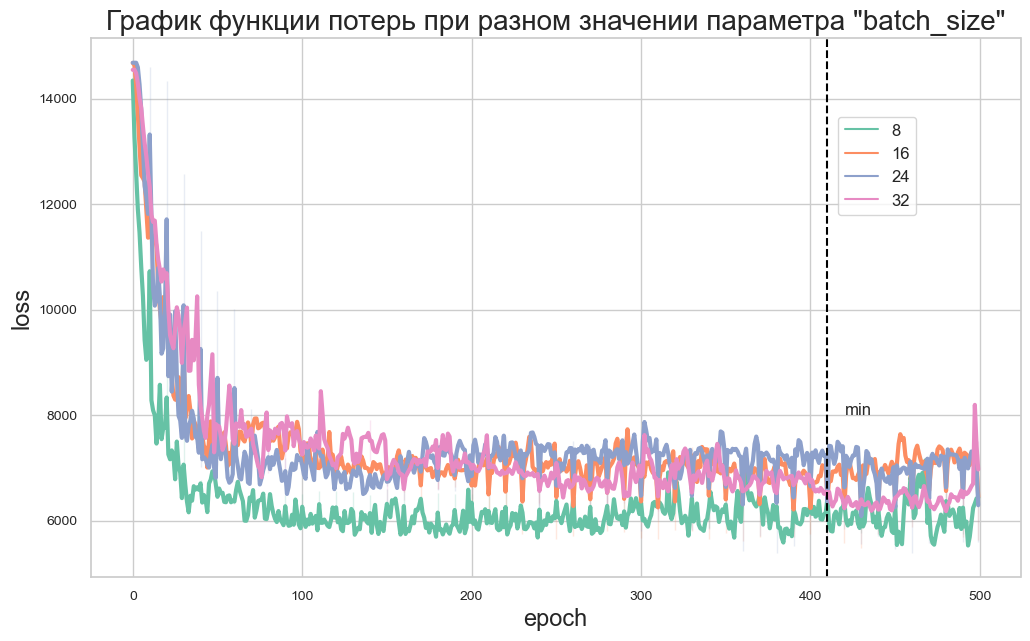

In [28]:
y = pd.concat([pd.Series(results_size_3), pd.Series(results_time_3), pd.Series(results_loss_3)], axis=1) 
y.columns = ['batch_size', 'epoch', 'loss']

sns.set(style="whitegrid")
plt.figure(figsize=(12, 7))

sns.lineplot(data=y, x='epoch', y='loss', hue='batch_size', palette="Set2", linewidth = 3.0)
plt.axvline(results_time_3[index], 0,1.0, color = 'black', linestyle='--')
plt.text (results_time_3[index]+10, 8000, 'min')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(0.897,0.87), prop={'size':12})
plt.xlabel('epoch', fontsize=17)
plt.ylabel('loss', fontsize=17)
plt.title('График функции потерь при разном значении параметра "batch_size"', fontsize=20)
plt.show();

In [33]:
class Model_improve(nn.Module):
    def __init__(self, n_hidden_neurons_1=4, n_hidden_neurons_2=4, activation_1=nn.ELU(), activation_2=nn.ELU(), 
                 activation_3=nn.ReLU(), dropout_1=0, dropout_2=0, optimizer=torch.optim.Adam):
        super(Model_improve, self).__init__()
        
        
        self.layer1 = nn.Linear(5, n_hidden_neurons_1)
        self.act1 = activation_1 
        #self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.dp1 = nn.Dropout(dropout_1)
        
        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = activation_2    
        #self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.dp2 = nn.Dropout(dropout_2)
        
        self.layer3 = nn.Linear(n_hidden_neurons_2, 1)
        self.act3 = activation_3    
        
        self.layer_names = ['layer1', 'layer2', 'layer3']
        self.optimizer = optimizer
        
    def init_weights(self):
        for layer in self.layer_names:
            if type(layer) == nn.Linear: 
                nn.init.normal_(layer.weight, mean= 0.0, std=1.14)
                nn.init.normal_(layer.bias, mean=-0.5, std=1.0) 
    
    def zero_grad_optimizer(self, set_to_none=None):
        
            if set_to_none is None:
                optimizer.zero_grad()
            else:
                optimizer.zero_grad(set_to_none=set_to_none)
       
    def forward(self, x):
        
        self.init_weights()
        self.zero_grad_optimizer()
        
        x = self.layer1(x)
        x = self.act1(x)
        #x = self.bn1(x)
        x = self.dp1(x)
        
        x = self.layer2(x)
        x = self.act2(x)
        #x = self.bn2(x)
        x = self.dp2(x)
        
        x = self.layer3(x)
        x = self.act3(x)
        return x    

In [34]:
scorers = make_scorer(mean_squared_error, squared=False) 

skorch_regressor = NeuralNetRegressor(module=Model_improve,   
                                      verbose=0,
                                      batch_size=8,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=500, 
                                      lr=0.07,
                                      train_split=skorch.dataset.ValidSplit(5), 
                                      criterion=torch.nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=scorers, lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping(lower_is_better=True, monitor='RMSE', patience=5)),
            ],
                                     ) 

params = {
     
    'module__n_hidden_neurons_1': [3, 4, 5],
    'module__n_hidden_neurons_2': [3, 4, 5],
        
    'module__dropout_1': [0, 0.1],
    'module__dropout_2': [0, 0.1],
    
    'module__activation_1': [nn.ReLU(), nn.ELU()],
    'module__activation_2': [nn.ReLU(), nn.ELU()],
    'module__activation_3': [nn.ReLU(), nn.ELU()],
        
    #'optimizer__lr': [0.001, 0.01, 0.05, 0.07],
    'lr': [0.001, 0.01, 0.05, 0.07],
    'batch_size': [8, 16, 24, 32]
}

grid_search = RandomizedSearchCV(skorch_regressor, params, cv=5, scoring='neg_root_mean_squared_error', verbose=0, n_iter=100) 
grid_search.fit(X_train_tensor, y_train_tensor.reshape(-1,1)) 
print()
print("Параметры лучшей модели:", grid_search.best_params_)


Параметры лучшей модели: {'module__n_hidden_neurons_2': 3, 'module__n_hidden_neurons_1': 4, 'module__dropout_2': 0, 'module__dropout_1': 0, 'module__activation_3': ELU(alpha=1.0), 'module__activation_2': ReLU(), 'module__activation_1': ReLU(), 'lr': 0.07, 'batch_size': 8}


In [35]:
train_preds = grid_search.best_estimator_.predict(X_train_tensor)
test_preds = grid_search.best_estimator_.predict(X_test_tensor)

print("Лучшее значение RMSE train: {:.3f}".format(mean_squared_error(y_train, train_preds, squared=False))) 
print("Лучшее значение RMSE test: {:.3f}".format(mean_squared_error(y_test, test_preds, squared=False)))  
print()

Лучшее значение RMSE train: 5021.721
Лучшее значение RMSE test: 6605.748



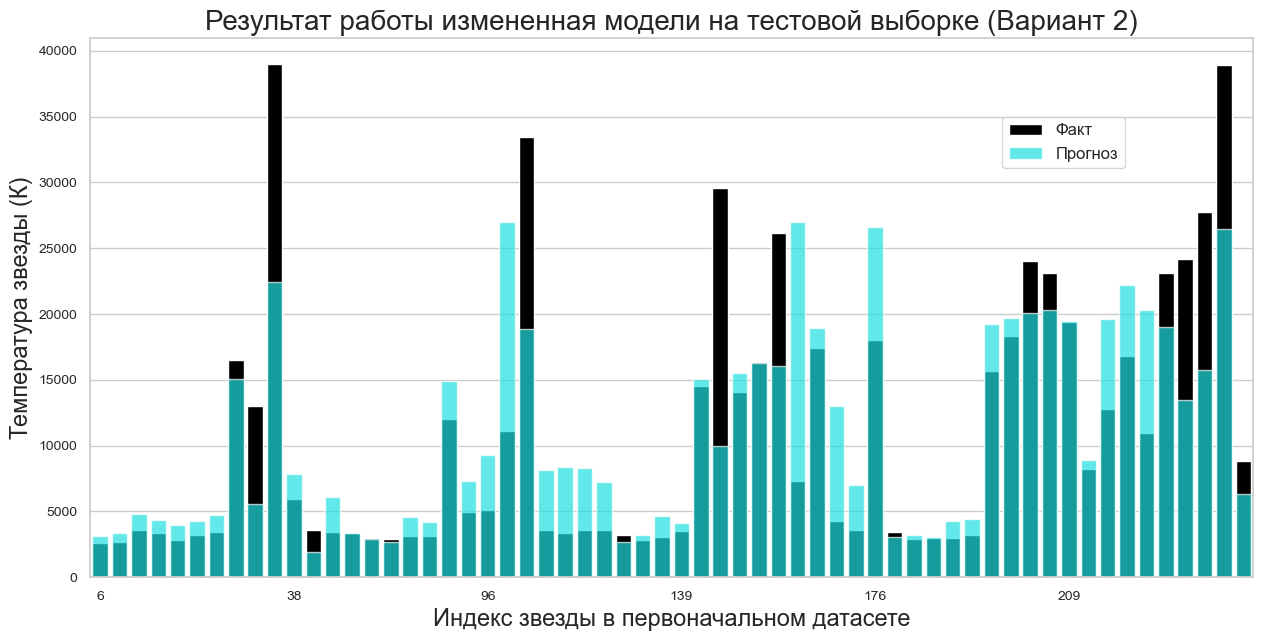

In [36]:
z = pd.concat([y_test.reset_index(), pd.Series(test_preds.flatten())], axis=1)

sns.set(style="whitegrid")
fig_3 = plt.figure(1, figsize=(15, 7))

sns.barplot(data=z, x='index', y='Temperature (K)', color ='black', alpha = 1, label='Факт')
sns.barplot(data=z, x='index', y=0, color ='cyan', alpha = 0.7, label='Прогноз')

plt.xticks(ticks=np.arange(0, len(x), 10), fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(0.897,0.87), prop={'size':12})
plt.xlabel('Индекс звезды в первоначальном датасете', fontsize=17)
plt.ylabel('Температура звезды (К)', fontsize=17)
plt.title('Результат работы измененная модели на тестовой выборке (Вариант 2)', fontsize=20)
plt.draw()

## Выводы